# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('../../data/datasets/action_images_dataset_v1.0')):
    X, y = load_data('../../data/datasets/action_images_dataset_v1.0', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 1895, Forehands count: 2293, Other count: 6142, Serve count: 1587
All strokes count: 11917


In [8]:
## Uncomment and run this cell with the desired num_examples count
## if you'd like to work with less data for testing purposes

# num_examples = 500
# X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=num_examples, stratify=y, random_state=42)
# X = X_sampled
# y = y_sampled

# bh_cnt = sum([1 for l in y if l == 'backhand'])
# fh_cnt = sum([1 for l in y if l == 'forehand'])
# other_cnt = sum([1 for l in y if l == 'other'])
# serve_cnt = sum([1 for l in y if l == 'serve'])
# print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
# print(f'All strokes count: {len(y)}')

## Isprobavanje metode potpornih vektora

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

In [9]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = SVC(kernel='rbf', gamma='scale', shrinking=True, random_state=7)
clf.fit(X_train, y_train)

SVC(random_state=7)

In [10]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [11]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.9409090909090909
Precision: 0.9295005410841184
Recall: 0.9270530074770853
F1 Score: 0.9282504603343497

Validation set scores:
Accuracy: 0.9142191142191142
Precision: 0.898220078280147
Recall: 0.8957185314604992
F1 Score: 0.8969265460207544


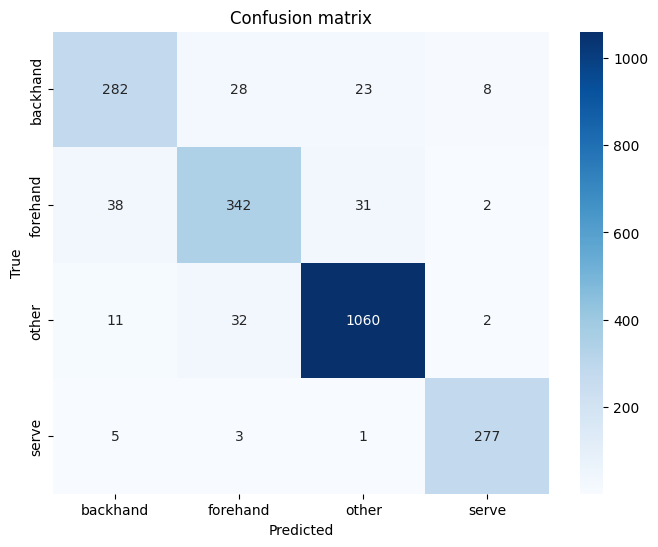

In [12]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [13]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.89      0.88      0.88      1364
    forehand       0.89      0.88      0.89      1651
       other       0.97      0.97      0.97      4423
       serve       0.97      0.97      0.97      1142

    accuracy                           0.94      8580
   macro avg       0.93      0.93      0.93      8580
weighted avg       0.94      0.94      0.94      8580



In [14]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.84      0.83      0.83       341
    forehand       0.84      0.83      0.84       413
       other       0.95      0.96      0.95      1105
       serve       0.96      0.97      0.96       286

    accuracy                           0.91      2145
   macro avg       0.90      0.90      0.90      2145
weighted avg       0.91      0.91      0.91      2145



## Pronalaženje najboljih hiperparametara

In [15]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [17]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'svc__C': [10**i for i in range(-2, 2)],
    'svc__kernel': ['sigmoid', 'rbf'],
    'svc__gamma': [10**i for i in range(-2, 2)],
}

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('svc', SVC(random_state=42))])

### Analiza hiperparametara

In [18]:
start = time.time()

grid_params_svc = GridSearchCV(grid_model, param_grid=params, scoring='f1_macro', verbose=True,
                               cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Time taken: 00:07:15.19


In [19]:
best_model = grid_params_svc.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc.best_score_}")
print(f"Best parameters: {grid_params_svc.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.8591341902949035
Best parameters: {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.9993443482821925
Precision: 0.9991508152173914
Recall: 0.9992145093906064
F1 Score: 0.9991816931449196

Validation set scores:
Accuracy: 0.9989512323020451
Precision: 0.9990644775904268
Recall: 0.9990644775904268
F1 Score: 0.9990644775904268


Odmah moramo primetiti potencijalno nerealno visoke procente, ali sačekaćemo da proces dođe do kraja i vidimo kako stojimo na test setu.

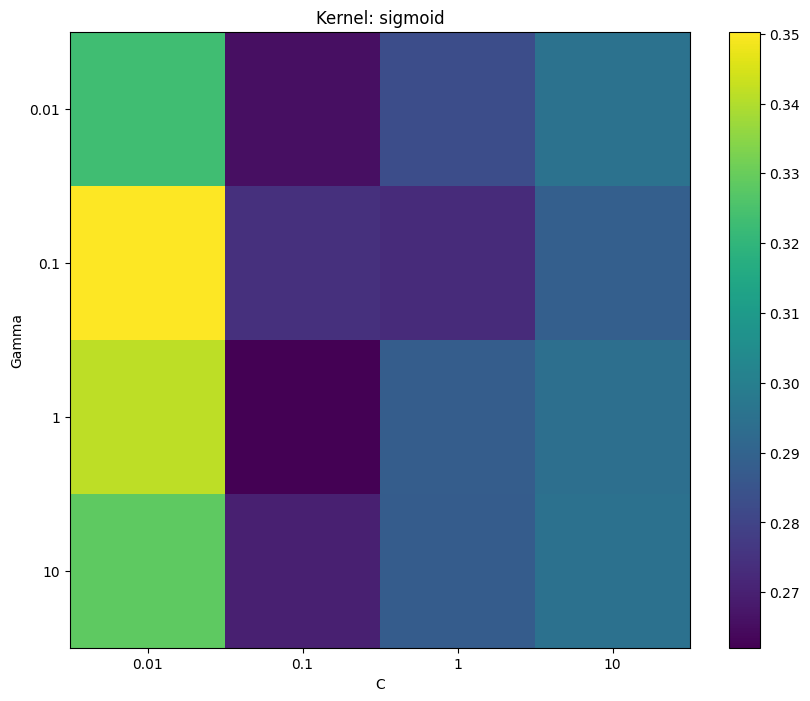

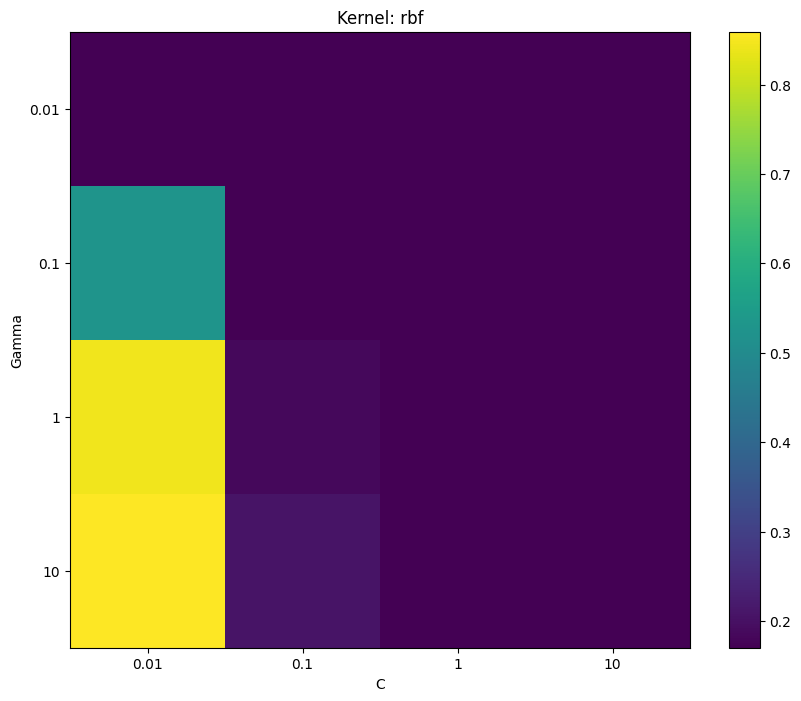

In [20]:
Cs = params['svc__C']
gammas = params['svc__gamma']
kernels = params['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Sa plotova vidimo da su optimalne vrednosti hiperparametra `gamma` za različite kernele u različitom smeru. Jednom odgovaraju veće, jednom manje. Tako da ćemo u nastavku pokrenuti pretragu parametara za svaki kernel posebno. Ovo radimo da bismo ispoštovali proceduru od ranije, a i iz radoznalosti šta se nalazi u prostoru parametara.

### Za sigmoid kernel

In [21]:
start = time.time()

params_sig = {
    'svc__C': [10**i for i in range(0, 6)],
    'svc__kernel': ['sigmoid'],
    'svc__gamma': [10**i for i in range(-7, 1)],
}

grid_params_svc_sig = GridSearchCV(grid_model, param_grid=params_sig, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc_sig.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Time taken: 00:05:52.61


In [22]:
best_model = grid_params_svc_sig.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_sig.best_score_}")
print(f"Best parameters: {grid_params_svc_sig.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.8885312524153152
Best parameters: {'svc__C': 100000, 'svc__gamma': 1e-06, 'svc__kernel': 'sigmoid'}

Training set scores:
Accuracy: 0.944400734329924
Precision: 0.9343407967895832
Recall: 0.933708233114267
F1 Score: 0.9340224111620679

Validation set scores:
Accuracy: 0.9365495542737283
Precision: 0.9246940882624618
Recall: 0.9291919223411332
F1 Score: 0.9266406887094198


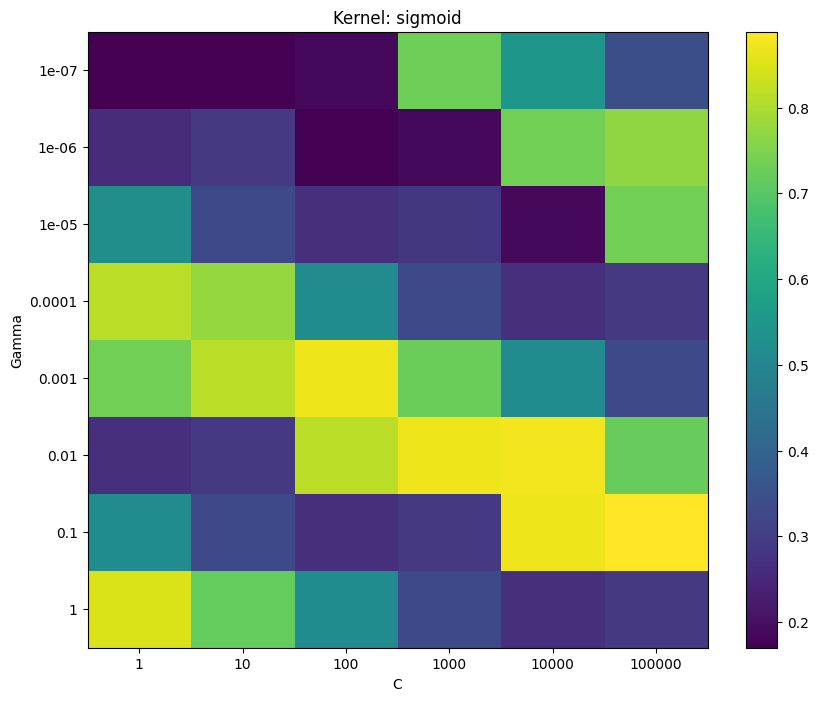

In [23]:
Cs = params_sig['svc__C']
gammas = params_sig['svc__gamma']
kernels = params_sig['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_sig.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

### Za rbf kernel

In [24]:
start = time.time()

params_rbf = {
    'svc__C': [10**i for i in range(-1, 3)],
    'svc__kernel': ['rbf'],
    'svc__gamma': [10**i for i in range(-5, 1)],
}

grid_params_svc_rbf = GridSearchCV(grid_model, param_grid=params_rbf, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc_rbf.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Time taken: 00:04:40.26


In [25]:
best_model = grid_params_svc_rbf.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_rbf.best_score_}")
print(f"Best parameters: {grid_params_svc_rbf.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.9255968996087267
Best parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.985575662208235
Precision: 0.9824088460348854
Recall: 0.9819759595338216
F1 Score: 0.9821848080949108

Validation set scores:
Accuracy: 0.9832197168327216
Precision: 0.9810216766475808
Recall: 0.9814584284121877
F1 Score: 0.9812345801003779


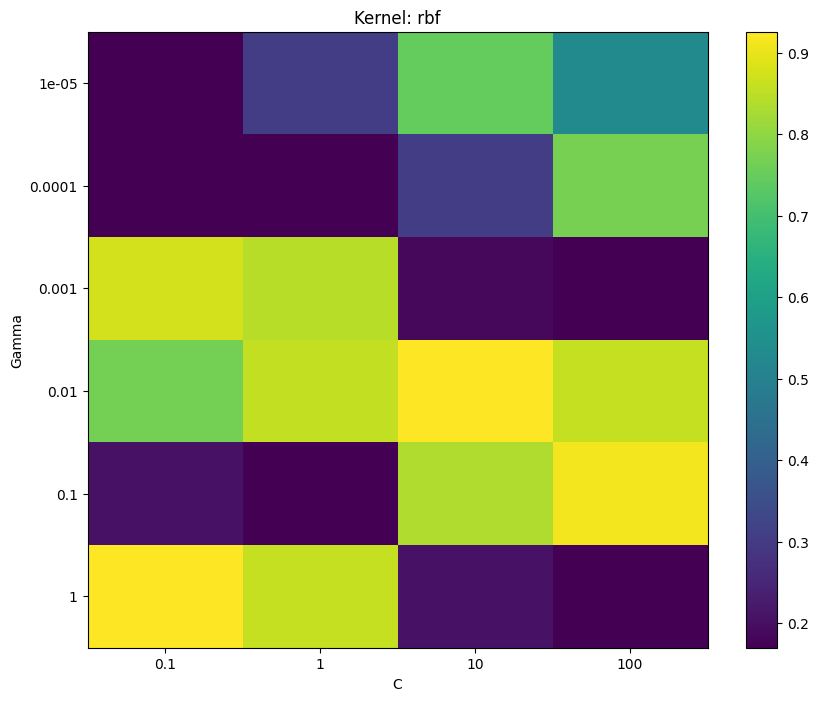

In [26]:
Cs = params_rbf['svc__C']
gammas = params_rbf['svc__gamma']
kernels = params_rbf['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_rbf.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Nakon analize oba kernela, biramo rbf i njegov najbolji model, između ostalog ima najbolji `mean_test_score` tako da ove rezultate proglašavamo konačnim kvalitetom modela. Napomena kao i u ostalim slučajevima, neće biti treniran model nad svim podacima iz skupa (uključujući i test), nego će biti eksportovana verzija trenirana nad trening i validacionim skupom da bi se prilikom demonstracije ili bilo kog daljeg koraka mogli koristiti primeri iz test skupa i dobijala relevantna predviđanja.

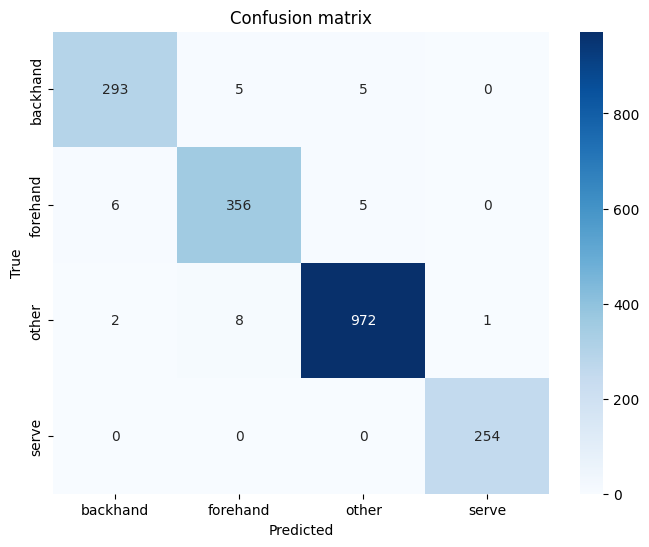

In [27]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.97      0.96      0.97      1213
    forehand       0.97      0.98      0.97      1467
       other       0.99      0.99      0.99      3930
       serve       1.00      1.00      1.00      1016

    accuracy                           0.99      7626
   macro avg       0.98      0.98      0.98      7626
weighted avg       0.99      0.99      0.99      7626



In [29]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.97      0.97      0.97       303
    forehand       0.96      0.97      0.97       367
       other       0.99      0.99      0.99       983
       serve       1.00      1.00      1.00       254

    accuracy                           0.98      1907
   macro avg       0.98      0.98      0.98      1907
weighted avg       0.98      0.98      0.98      1907



Ovaj model daje zaista sjajne rezultate i možemo se samo nadati da su naši transformisani podaci (sličice) koji predstavljaju udarce (video klipove od jedne sekunde) poprilično razdvojivi nekom nelinearnom granicom. U nastavku ćemo videti ponašanje na test skupu da ovu ideju bar malo testiramo.

## Procena modela na test skupu

In [30]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.9337248322147651
Precision: 0.9230796679334022
Recall: 0.9142996997036099
F1 Score: 0.9185376272160904


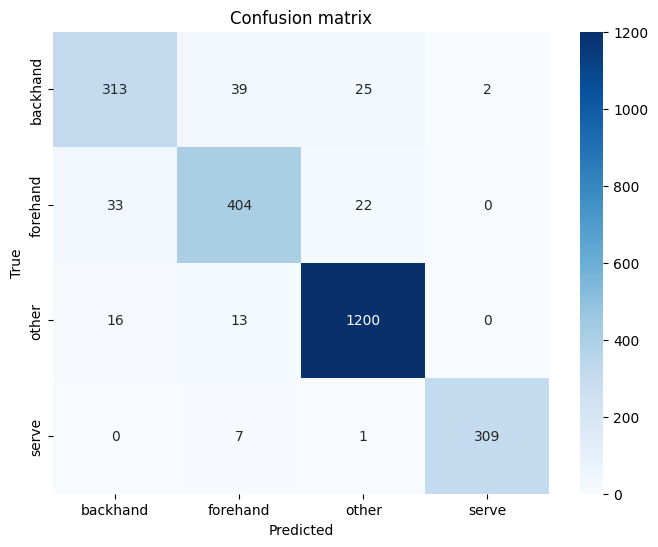

In [31]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.86      0.83      0.84       379
    forehand       0.87      0.88      0.88       459
       other       0.96      0.98      0.97      1229
       serve       0.99      0.97      0.98       317

    accuracy                           0.93      2384
   macro avg       0.92      0.91      0.92      2384
weighted avg       0.93      0.93      0.93      2384



Ipak kao i u svim implementiranim slučajevima dobijamo nešto lošije rezultate za test skup, ipak ovi rezultati za SVM su zaista fenomenalni. Posebno ako na primer pogledamo izdvojene klase `other` i `serve`, za koje radi skoro savršeno.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [33]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/03_svm_relabeled_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)